# Time-shifted Data

In this tutorial, we show how to transform the time-series data in the following ways:
* `split` time-series with a lot of data points into mutiple segments, and
* `time shift` the above segments so that they have the same timestamps.

The above transformations allow you to easily compare the data over the last hour/day/week over the previous intervals. This helps you understand if your system's current behavior continues to match the past behavior.

**Note**: This tutorial reads in metric data from the Monitoring API, or a Google Cloud Storage bucket:
* If the variable `'common_prefix'` is set, the data is read from the Monitoring API.
* If the variable `'common_prefix'` is not set, the data is loaded from a shared Cloud Storage bucket. See [here](../Storage/Storage APIs.ipynb) to learn more about the Storage API.


## Load the monitoring module and set the default project

If there is no default project set already, you must do so using 'set_datalab_project_id'. 

In [1]:
from datalab.stackdriver import monitoring as gcm

# set_datalab_project_id('my-project-id')

## Find the most common instance name prefixes

The prefix from an instance name is calculated by splitting on the last '-' character. All instances with the same prefixes are grouped together to get the prefix counts.

In [2]:
import collections

# Initialize the query for CPU utilization over the last week, and read in its metadata.
query_cpu = gcm.Query('compute.googleapis.com/instance/cpu/utilization', hours=7*24)
cpu_metadata = query_cpu.metadata()

# Count the occurrences of each prefix, and display the top 5.
instance_prefix_counts = collections.Counter(
  timeseries.metric.labels['instance_name'].rsplit('-', 1)[0]
  for timeseries in cpu_metadata)
instance_prefix_counts.most_common(5)

[(u'aggregator', 50),
 (u'cassandra', 12),
 (u'alerting', 11),
 (u'apache', 6),
 (u'alerting-test', 5)]

## Select the instance name prefix to filter on

In this cell, you can select an instance name prefix to filter on. If you do not set this variable, then the data is read from a Cloud Storage bucket.

You can look at the most frequent prefix in the previous cell. It is recommended that you select a prefix with the following properties:
* the instances have the CPU Utilization metric data for at least the last 5 days
* the instances span multiple zones

In [3]:
# Set this variable to read data from your own project.
common_prefix = None # 'my-instance-prefix'

if common_prefix is None:
  print('No prefix specified. The data will be read from a Cloud Storage bucket.')
else:
  print('You selected the prefix: "%s"' % (common_prefix,))

No prefix specified. The data will be read from a Cloud Storage bucket.


## Load the time series data

Based on the value of `'common_prefix'` in the previous cell, the time series data is loaded from the Monitoring API, or a shared Cloud Storage bucket.

In both cases, we load the time series of the CPU Utilization metric over the last week, aggregated to hourly intervals per zone.

In [4]:
import StringIO

import pandas 

import datalab.storage as storage


if common_prefix is None:
  print('Reading in data from a Cloud Storage Bucket')
  
  # Initialize the bucket name, and item key.
  bucket_name = 'cloud-datalab-samples'
  per_zone_data = 'stackdriver-monitoring/timeseries/per-zone-weekly-20161010.csv'

  # Load the CSV from the bucket, and intialize the dataframe using it.
  per_zone_data_item = storage.Bucket(bucket_name).item(per_zone_data)
  per_zone_data_string = StringIO.StringIO(per_zone_data_item.read_from())
  per_zone_cpu_data = pandas.DataFrame.from_csv(per_zone_data_string)
  
else:
  print('Reading in data from the Monitoring API')
  
  # Filter the query to instances with the specified prefix.
  query_cpu = query_cpu.select_metrics(instance_name_prefix=common_prefix)

  # Aggregate to hourly intervals per zone.
  query_cpu = query_cpu.align(gcm.Aligner.ALIGN_MEAN, hours=1)
  query_cpu = query_cpu.reduce(gcm.Reducer.REDUCE_MEAN, 'resource.zone')

  # Get the time series data as a dataframe, with a single-level header.
  per_zone_cpu_data = query_cpu.as_dataframe(label='zone')
  
per_zone_cpu_data.tail(5)

Reading in data from a Cloud Storage Bucket


,asia-east1-a,us-central1-a
2016-10-10 16:32:00,0.011766,0.065117
2016-10-10 17:32:00,0.011717,0.063885
2016-10-10 18:32:00,0.010925,0.063627
2016-10-10 19:32:00,0.011361,0.064100
2016-10-10 20:32:00,0.011607,0.063849


## Split the data into daily chunks

Here, we split the data over daily boundaries.

In [5]:
import collections

# Extract the number of days in the dataframe.
num_days = len(per_zone_cpu_data.index)/24

# Split the big dataframe into daily dataframes.
daily_dataframes = [per_zone_cpu_data.iloc[24*i: 24*(i+1)]
                    for i in xrange(num_days)]

# Reverse the list to have today's data in the first index.
daily_dataframes.reverse()

# Display the last five rows from today's data.
daily_dataframes[0].tail(5)

,asia-east1-a,us-central1-a
2016-10-10 16:32:00,0.011766,0.065117
2016-10-10 17:32:00,0.011717,0.063885
2016-10-10 18:32:00,0.010925,0.063627
2016-10-10 19:32:00,0.011361,0.064100
2016-10-10 20:32:00,0.011607,0.063849


## Initialize a helper function

Here, we initialize a helper function to create human readable names for days.

In [6]:
TODAY = 'Today'

# Helper function to make a readable day name based on offset from today.
def make_day_name(offset):
  if offset == 0:
    return TODAY
  elif offset == 1:
    return 'Yesterday'
  return '%d days ago' % (offset,)

## Time-shift all dataframes to line up with the last day

The pandas method [tshift](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.tshift.html) lets you shift a dataframe by a specified offset. We use this to shift the index of all days to match the timestamps in the latest day.

The data for each zone is inserted in a differenct dataframe, where the rows are timestamps and columns are specific days.

In [7]:
# Extract the zone names.
all_zones = per_zone_cpu_data.columns.tolist()

# Use the last day's timestamps as the index, and initialize a dataframe per zone.
last_day_index = daily_dataframes[0].index
zone_to_shifted_df = {zone: pandas.DataFrame([], index=last_day_index)
                      for zone in all_zones}

for i, dataframe in enumerate(daily_dataframes):
  # Shift the dataframe to line up with the start of the last day.
  dataframe = dataframe.tshift(freq=last_day_index[0] - dataframe.index[0])
  current_day_name = make_day_name(i)
  
  # Insert each daily dataframe as a column into the dataframe.
  for zone in all_zones:
    zone_to_shifted_df[zone][current_day_name] = dataframe[zone]
    
# Display the first five rows from the first zone.    
zone_to_shifted_df[all_zones[0]].head(5)

,Today,Yesterday,2 days ago,3 days ago,4 days ago,5 days ago,6 days ago
2016-10-09 21:32:00,0.011533,0.011262,0.011339,0.011408,0.011781,0.011702,0.012291
2016-10-09 22:32:00,0.011584,0.011749,0.011622,0.011911,0.012058,0.011558,0.011693
2016-10-09 23:32:00,0.012230,0.011381,0.011772,0.011889,0.012022,0.011891,0.011475
2016-10-10 00:32:00,0.011892,0.011705,0.012105,0.011908,0.012239,0.011859,0.011672
2016-10-10 01:32:00,0.011936,0.011884,0.011726,0.012394,0.011723,0.012453,0.012195


## Compare the CPU utilization day-over-day

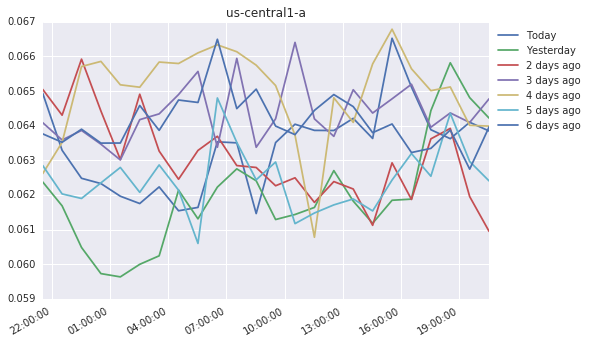

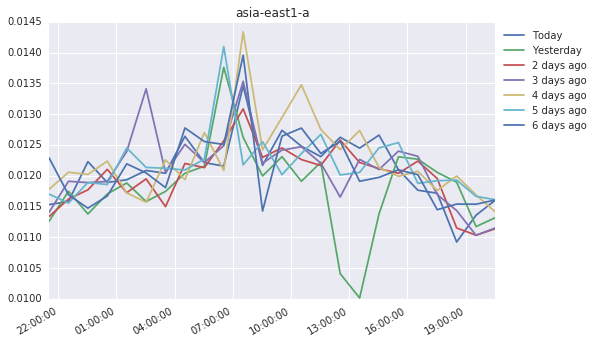

In [8]:
for zone, dataframe in zone_to_shifted_df.iteritems():
  dataframe.plot(title=zone).legend(loc="upper left", bbox_to_anchor=(1,1))

## Compare today's CPU Utilization to the weekly average

In order to compare the metric data for today, with the average of the week, we create new dataframes with the following columns:
* Today's data: From the original data for TODAY
* Average over the week: From the mean across all the days

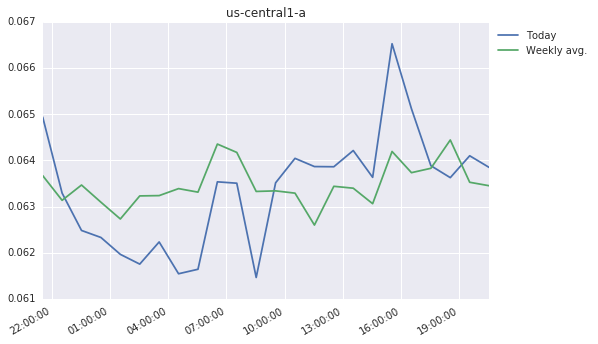

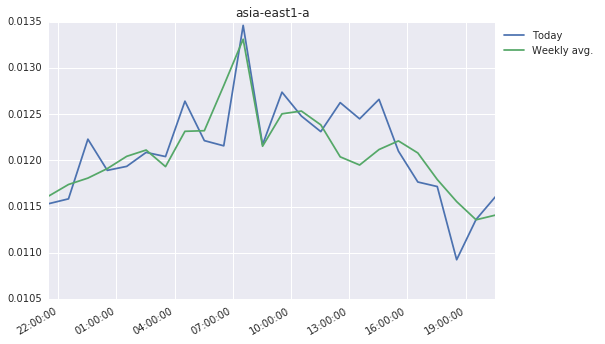

In [9]:
for zone, dataframe in zone_to_shifted_df.iteritems():
  # Initialize the dataframe by extracting the column with data for today.
  compare_to_avg_df = dataframe.loc[:, [TODAY]]
  
  # Add a column with the weekly avg.
  compare_to_avg_df['Weekly avg.'] = dataframe.mean(axis=1)
  
  # Plot this dataframe.
  compare_to_avg_df.plot(title=zone).legend(loc="upper left", bbox_to_anchor=(1,1))